In [1]:
from nltk.stem.porter import PorterStemmer
import json
import re
import glob
import math
from numpy import *
import numpy as np
import matplotlib.pyplot as plt

# Data Pre-Process (Zhong)
Delete the users and restaurants with few comments to avoid "Cold-Start Problem"


# Data Process (Wang)
Cluster the pre-processed data using word2vec

# Latent Factors + Bias
Using Latent Factor Model + User and Item bias to obtain "user-concept" and "item-concept" Matrices

In [48]:
## objectives
## 1. get the number of users & items in training data. Entry of matrix

## interface:
## input(1)
#    name of a file
## output(2)
#    user_id: a list of distinct users
#    business_id: a list of distinct restaurant

def matrix_entry(file_name):
    # get the size of user_id & business_id
    user_id = []
    business_id = []
    with open(file_name) as f:
        for line in f:
            temp = json.loads(line)        
            user_id.append(temp["user_id"])
            business_id.append(temp["business_id"])
    # This is without duplication: set
    user_id = list(set(user_id))
    business_id = list(set(business_id))
    return [user_id, business_id]

# file_name = 'yelp_data/training_at5.json'
file_name = 'proj_data/cluster9.json'
[user_id, business_id] = matrix_entry(file_name)
print user_id.__len__()
print business_id.__len__()
print "done"

16274
1428
done


In [11]:
print user_id[0]
print business_id[0]

MUsXhUuDRzGLkh2l3aNDGA
bxUZorggwGDpU_liCTZazw


In [3]:
## Objectives
## 1. calculate the "Global Average" with variable name "average"
## 2. user bias of all users with variable name "origin_user_bias"
#     it is a dictionary = {user_id --> user average score}
#     intermedia variable: user_bias_list = {user_id --> a list of scores}
## 3. restaurant bias of all restaurants with variable name "origin_restaurant_bias"
#     it is a dictionary = {business_id --> restaurant averate score}
#     intermedia variable: business_bias_list = {business_id --> a list of scores}

## interface:
## input(3:
#    name of a file
#    user_id
#    business_id
#
## output(3):
#    global average
#    origin_user_bias
#    origin_business_bias
def baseline(file_name, user_id, business_id):
    average = 0
    num_star = 0
    user_bias_list = {}
    origin_user_bias = {}
    business_bias_list = {}
    origin_business_bias = {}
    for value in user_id:
        user_bias_list[value] = []
        origin_user_bias[value] = 0
    for value in business_id:
        business_bias_list[value] = []
        origin_business_bias[value] = 0

    # adding the list
    with open(file_name) as f:
        for line in f:
            # get the infor from file
            temp = json.loads(line)        
            cur_user_id = temp["user_id"]
            cur_business_id = temp["business_id"]
            star = temp["stars"]
            # filling the dictionary & calculate the average
            average += star
            num_star += 1
            user_bias_list[cur_user_id].append(star)
            business_bias_list[cur_business_id].append(star)

    # average
    average /= float(num_star)
    # calculate: user_bias = {user_id --> average score} & business_bias = {business_id --> average score}
    for user_key in user_bias_list:
        b_x = sum(user_bias_list[user_key]) / float(user_bias_list[user_key].__len__()) - average
        origin_user_bias[user_key] = b_x
    for business_key in business_bias_list:
        b_i = sum(business_bias_list[business_key]) / float(business_bias_list[business_key].__len__()) - average
        origin_business_bias[business_key] = b_i
    return [average, origin_user_bias, origin_business_bias]

file_name = 'yelp_data/training_at5.json'
[average, origin_user_bias, origin_business_bias] = baseline(file_name, user_id, business_id)
print "done"

done


In [4]:
## Objective:
## 1. Make "user_id" and "business_id" in the data match the index in latent factor model

## interface
## input():
#    user_id
#   business_id
## output():
#    
def matching(user_id, business_id):
    # user_id = list(user_id)
    user_idx = range(user_id.__len__())
    user_match = dict(zip(user_id, user_idx))

#     business_id = list(business_id)
    business_idx = range(business_id.__len__())
    business_match= dict(zip(business_id, business_idx))
    return [user_match, business_match]

[user_match, business_match] = matching(user_id, business_id)
print "done"

done


In [5]:
## Objective:
## 1. Sochastic Gradient Decent training function with bias

## SGD training function interface
## inputs(10):
#    file_name: training file
#    ite: number of iteration
#    lam: regulation factor: assume lam1 == lam2 == lam3 == lam4
#    mu: study rate: assume mu1 = mu2
#    k: number of concept in latent factor
#    m: number of users
#    n: number of items (restaurant)
#    user_match: from user_id to index i
#    business_match: from business_id to index j
#    user_bias & business_bias: should equal to "original user_bias & business_bias", whose values won't change
#    average: global average
## outputs(4):
#    latent factor q & p, updated user_bias & business_bias

def SGD_train(file_name, ite, lam, mu, k, m, n, user_match, business_match, user_bias, business_bias, average):
    # initialization
    q = np.random.rand(m, k) * sqrt(5.0 / k)  # normalization
    p = np.random.rand(n, k) * sqrt(5.0 / k)
    fig = empty(ite)

    ## essential steps
    # 1. read the file to get user_id, business_id, stars
    # 2. find the corresponding index of user_id, business_id in q and p
    # 3. Stochastic GD alg
    for num in range(0, ite):
#         print num
        # read the file to update q & p
        with open(file_name) as f:
            for line in f:
                temp = json.loads(line)
                cur_user_id = temp["user_id"]
                cur_business_id = temp["business_id"]
                # get initialized b_x, b_i
                b_x = user_bias[cur_user_id]
                b_i = business_bias[cur_business_id]
                i = user_match[cur_user_id]                  # get the index of corresponding user in q
                j = business_match[cur_business_id]          # get the index of corresponding business in p
                star = temp["stars"]
                # updating p, q, b_x & b_i
                eps = 2 * (star - (average + b_x + b_i + dot(q[i, ], p[j, ])))
                temp_q = q[i, ] + mu * (eps * p[j, ] - 2 * lam * q[i, ])
                temp_p = p[j, ] + mu * (eps * q[i, ] - 2 * lam * p[j, ])
                q[i, ] = temp_q
                p[j, ] = temp_p
                user_bias[cur_user_id] = b_x + mu * (eps - 2 * lam * b_x)
                business_bias[cur_business_id] = b_i + mu * (eps - 2 * lam * b_i)
    
        # read the file to calculate the error
#         error = 0
#         with open(file_name) as f:
#             for line in f:
#                 temp = json.loads(line)
#                 cur_user_id = temp["user_id"]
#                 cur_business_id = temp["business_id"]
#                 i = user_match[cur_user_id]
#                 j = business_match[cur_business_id]
#                 b_x = user_bias[cur_user_id]
#                 b_i = business_bias[cur_business_id] 
#                 star = temp["stars"]
#                 error += (star - (average + b_x + b_i + dot(q[i, ], p[j, ]))) ** 2
#         # add the regulation error (combine them in all)
#         # regulation for b_x & b_i
#         regu_user_bias = 0
#         regu_business_bias = 0
#         for key in user_bias:
#             regu_user_bias += user_bias[key] ** 2
#         for key in business_bias:
#             regu_business_bias += business_bias[key] ** 2
#         error += lam * (sum(q ** 2) + sum(p ** 2) + regu_user_bias + regu_business_bias)
#         fig[num] = error        

#     # examine: plot the graph 
#     plt.plot(range(0, ite), fig)
#     plt.show()            
#     print error             
#     print "done"
    return q, p, user_bias, business_bias

In [6]:
## Objective:
## 1. Sochastic Gradient Decent testing function with bias

## SGD testing function with baseline interface
## input(7):
#    file_name: testing file
#    q and p: learned latend factor model
#    user_match & business_match
#    user_bias & business_bias: learned bias
#    average
## output(1):
#    RMSE
def SGD_test(file_name, q, p, user_match, business_match, user_bias, business_bias, average):
    extrapolate_star = []
    origin_star = []
    size = 0
    RMSE = 0
    with open(file_name) as f:
        for line in f:
            temp = json.loads(line)
            cur_user_id = temp["user_id"]
            cur_business_id = temp["business_id"]
            # check if current review is in the Matrix
            if cur_user_id in user_match and cur_business_id in business_match:
                size += 1
                i = user_match[cur_user_id]
                j = business_match[cur_business_id]
                star = temp["stars"]
                b_x = user_bias[cur_user_id]
                b_i = business_bias[cur_business_id] 
                RMSE += (star - (average + b_x + b_i + dot(q[i, ], p[j, ]))) ** 2
        RMSE = sqrt(RMSE / float(size))    
    return RMSE

0.7
1.06317357593


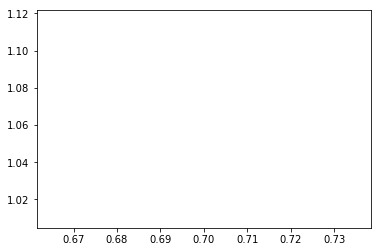

done


In [7]:
## Tuning Prameter
#    1. tune "lam"

ite = 15                                  
# lam = [(x + 1) / float(10) for x in range(3, 15)]
lam = [0.7]
mu = 0.005                                
k = 20                                    
m = user_id.__len__()                     
n = business_id.__len__()        
output = empty(lam.__len__())
train_file = 'yelp_data/training_at5.json'
test_file = 'yelp_data/testing_at5.json'

for cur_lam in lam:
    user_bias = dict(origin_user_bias)
    business_bias = dict(origin_business_bias)
    # training
    [q, p, user_bias, business_bias] = SGD_train(
        train_file, ite, cur_lam, mu, k, m, n, user_match, business_match, user_bias, business_bias, average)
    # testing
    RMSE = SGD_test(test_file, q, p, user_match, business_match, user_bias, business_bias, average)
    output[lam.index(cur_lam)] = RMSE
    print cur_lam
    print RMSE

plt.plot(lam, output)
plt.show()                
print "done"    

# Aggregation the final results

In [13]:
## don't run this cell
train_file = "yelp_data/training_at5.json"
# construct & initialize the dictionary
cluster = {}
for user_key in user_id:
    cluster[user_key] = {}
    for business_key in business_id:
        cluster[user_key][business_key] = 0

# filling the dictionary
for user_key in user_id:
    for business_key in business_id:
        i = user_match[user_key]
        j = business_match[business_key]
        b_x = user_bias[user_key]
        b_i = business_bias[business_key]  
        # assign the score
        cluster[user_key][business_key] = average + b_x + b_i + dot(q[i, ], p[j, ])
    
print "done"

done


In [12]:
print cluster["MUsXhUuDRzGLkh2l3aNDGA"]["bxUZorggwGDpU_liCTZazw"]

0


In [ ]:
## objective: calculate each "q, p, user_bias, business_bias, user_match, business_match" within each cluster
# read all files in the training file

## "cluster_data" collects all latent factor & its corresponding data in a dectionary. Key is just number
#    the data format is cluster_data[key] = [q, p, user_bias, business_bias, user_match, business_match]
cluster_data = {}
cluster_key = 0
for filename in glob.glob('proj_data/*.json'):
    # create a dictionary for cluster
    cluster_data[cluster_key] = []

    # get the user_id & business_id in a file
    [user_id, business_id] = matrix_entry(filename)
    # get the matching 
    [user_match, business_match] = matching(user_id, business_id)
    # calculate its corresponding baseline
    [average, origin_user_bias, origin_business_bias] = baseline(filename, user_id, business_id)
    # SGD training 
    [q, p, user_bias, business_bias] = SGD_train(
        filename, ite, cur_lam, mu, k, m, n, user_match, business_match, user_bias, business_bias, average)
    
    cluster_data[cluster_key].append(q)
    cluster_data[cluster_key].append(p)
    cluster_data[cluster_key].append(user_bias)
    cluster_data[cluster_key].append(business_bias)
    cluster_data[cluster_key].append(user_match)
    cluster_data[cluster_key].append(business_match)
    cluster_key += 1

    
print "done"

In [43]:
## single cluster creation
def singleCluster(file_name, lam):
    # get the user_id & business_id in a file
    [user_id, business_id] = matrix_entry(file_name)
    # get the matching 
    [user_match, business_match] = matching(user_id, business_id)
    # calculate its corresponding baseline
    [average, user_bias, business_bias] = baseline(file_name, user_id, business_id)
    
    # set the parameter
    ite = 15                                  
    mu = 0.005                                
    k = 20                                    
    m = user_id.__len__()                     
    n = business_id.__len__()  
    
    # SGD training 
    [q, p, user_bias, business_bias] = SGD_train(
        file_name, ite, lam, mu, k, m, n, user_match, business_match, user_bias, business_bias, average)
    # current cluster
    cur_cluster = []
    cur_cluster.append(q)
    cur_cluster.append(p)
    cur_cluster.append(user_bias)
    cur_cluster.append(business_bias)
    cur_cluster.append(user_match)
    cur_cluster.append(business_match)
    return cur_cluster
    
# implement the method
# file_name = 'yelp_data/training_at5.json'
file_name = "proj_data/cluster9.json"
cur_lam = 0.2
single_cluster = singleCluster(file_name, cur_lam)
print "done"

ValueError: Unterminated string starting at: line 1 column 150 (char 149)

In [49]:
## multiple clusters
def multiCluster(directory):
    cluster_data = {}
    cluster_key = 0
    for file_name in glob.glob(directory):
        print cluster_key
        # create a dictionary for cluster
        cur_lam = 0.2
        cluster_data[cluster_key] = clusterInfor(file_name, cur_lam)
        cluster_key += 1
    return cluster_data

directory = 'proj_data/*.json'
all_cluster = multiCluster(directory)
print "done"        

0
1
2
3
4
5
6
7
done


In [ ]:
def aggregationTest(file_name, cluster):
    size = 0
    RMSE = 0
    with open(file_name) as f:
        for line in f:
            temp = json.loads(line)
            cur_user_id = temp["user_id"]
            cur_business_id = temp["business_id"]

            m=0
            num=0
            if cur_user_id in cluster[1][4] and cur_business_id in cluster[1][5]:
                size += 1

                for x in range(0,9):
                    if cur_user_id in cluster[x][4] and cur_business_id in cluster[x][5]:
                        num+=1

                        i = cluster[x][4][cur_user_id]
                        j = cluster[x][5][cur_business_id]

                        star = temp["stars"]

                        b_x = cluster[x][2][cur_user_id]
                        b_i = cluster[x][3][cur_business_id] 
                        m+=(average + b_x + b_i + dot(cluster[x][0][i, ], cluster[x][1][j, ]))
                score=m/num

                RMSE += (star - score) ** 2
        RMSE = sqrt(RMSE / float(size))    
    return RMSE



In [28]:
print all_cluster[3]

[array([[ 0.37575384,  0.08820803,  0.00920463, ...,  0.0047706 ,
         0.45336753,  0.42561736],
       [ 0.03293673,  0.35132713, -0.028926  , ...,  0.24865437,
        -0.01040401, -0.01567223],
       [ 0.03405563,  0.09416759,  0.15695052, ...,  0.04778254,
         0.40005964,  0.04342824],
       ..., 
       [ 0.29946938,  0.24139657,  0.3580455 , ...,  0.14254091,
         0.39809764, -0.00134307],
       [ 0.10388089,  0.37853385,  0.37551004, ...,  0.25939966,
         0.15601791, -0.00169825],
       [ 0.41672328,  0.07265082,  0.27243813, ...,  0.43628298,
         0.14479171,  0.45431473]]), array([[-0.02054926,  0.00955145,  0.07597163, ...,  0.12825469,
         0.00461415,  0.10694496],
       [ 0.1751122 ,  0.08249965,  0.11154441, ...,  0.25330305,
         0.0071911 ,  0.07109129],
       [ 0.10673228,  0.28021375,  0.08897736, ...,  0.00781747,
         0.04366535,  0.12813805],
       ..., 
       [ 0.19652687,  0.21002968,  0.02186169, ...,  0.25155177,
      

# Final Test: RMSE

In [ ]:
## Test Rest

# Comparison
1. Global Average
2. Plus Bias 
3. Latent Factor
4. Latent Factor with bias
5. Cluster & Aggregation
